# Intro

This notebook loads the fraud datasets, does some miminal exploratory data analysis and feature engineering, and then trains a Random Forest model to predict fraud. A lot of the more extensive work (extended EDA, model selection, hyperparameter tuning, deeper model evaluation, etc) has been removed to keep this exercise simple. 

# Configure environment

In [25]:
# install required libraries if needed
# !pip install -Iv category_encoders==2.2.2
# !pip install -Iv matplotlib==3.3.2
# !pip install -Iv numpy==1.19.2
# !pip install -Iv pandas==1.1.3
# !pip install -Iv seaborn==0.11.0
# !pip install -Iv sklearn==0.23.2

# Loading and Viewing the Data

In [26]:
# Import needed libraries and load the data to pandas dataframes 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
transaction = pd.read_csv(open('data/transaction.csv', 'rb'))
identity = pd.read_csv(open('data/identity.csv', 'rb'))

In [16]:
# View the two datasets
transaction

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,V302,V303,V304
0,2987000,0,86400,68.50,W,13926,0.0,0.0,0.0
1,2987001,0,86401,29.00,W,2755,0.0,0.0,0.0
2,2987002,0,86469,59.00,W,4663,0.0,0.0,0.0
3,2987003,0,86499,50.00,W,18132,0.0,0.0,0.0
4,2987004,0,86506,50.00,H,4497,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,0.0,0.0,0.0
590536,3577536,0,15811049,39.50,W,10444,0.0,0.0,0.0
590537,3577537,0,15811079,30.95,W,12037,0.0,0.0,0.0
590538,3577538,0,15811088,117.00,W,7826,0.0,0.0,0.0


In [17]:
identity

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
144228,3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN
144229,3577526,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN
144230,3577529,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN
144231,3577531,-5.0,55528.0,0.0,0.0,0.0,-7.0,NaN,NaN



We have 2 large datasets linked by the **TransactionID** field. 

For the **Transaction** dataset we have 590540 rows

*   **TransactionID**: the unique identifier of our dataset
*   **isFraud**: a boolean Fraud indicator
* **TransactionDT**: A datetime delta, starting with 86400, the number of seconds in a day. This suggests that the unit of this field is seconds from an unknown reference datetime.
*	**TransactionAmt**: USD amount to be transacted
*	**ProductCD**: A product code
*	**card1**: Payment card type

We understand that for privacy concerns, the fields in **Identity** are masked and thus going to be difficult to interpret. We have 144233 observations here and see that many of them are missing values. 


### Joining datasets
We can left join Transaction with Identity to preserve all the Transaction observations and give additional information from the id fields for the observations where they are available. We will have many null values after.

In [18]:
combined = pd.merge(transaction, identity, how="left", on=["TransactionID"])
combined

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,V302,V303,V304,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08
0,2987000,0,86400,68.50,W,13926,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,1.0,1.0,1.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature Engineering 
We decide to build a classification algorithm for determining fraud. Given our volume of missing data, we choose to impute data. 

We will build a Random Forest (RF) model. We prepare the data for a random forest approach. We can keep all the Identity features as is and the datetime measure as well. We will still need to figure out what to do with the **Card1** categorical feature.

In [19]:
combined['card1_v2'] =combined.card1 // 1000
combined.groupby('card1_v2', as_index=False)['isFraud'].agg(['mean','count']).reset_index()

,card1_v2,mean,count
0,1,0.032123,28858
1,2,0.037077,39405
2,3,0.045438,24935
3,4,0.036499,26686
4,5,0.049167,24203
5,6,0.029362,33853
6,7,0.024060,55404
7,8,0.028656,24532
8,9,0.062066,45339
9,10,0.041195,37699


First we impute our missing values. We use the median, which assumes that most of our missing data looks like the median for what's available and that our data is missing completely at random (MCAR). 

In [20]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

#Creating features and imputing with median for missing features
X = combined.drop(columns = ["TransactionID","card1_v2","isFraud"])
X = pd.get_dummies(data=X, drop_first=True)	

imp = SimpleImputer(missing_values=np.NaN, strategy='median')

imputed_X = pd.DataFrame(imp.fit_transform(X))
imputed_X.columns=X.columns
imputed_X.index=X.index
X = imputed_X

#Target values
y = combined.isFraud

#Stratified Test Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=23, stratify=y)

### Target Encoding for Card1

To avoid the curse of dimensionality, we want to recode our **Card1** to represent instead a rough estimate of **isFraud** rate for each available value in our training set. We are focusing on the relationship between the category and the mean of the target. 

We must be prudent about data leakage and overfitting when encoding. Smoothing and min_samples_leaf are 2 hyperparameters which can be adjusted for this regularization purpose. Smoothing determines the weighting between the an individual category mean compare to the entire category and min_samples_leaf provides a lower sample bound before taking into consideration the mean. These two parameters set out to minimize the influence of low sample sizes for a category.

In [21]:
#Replacing categorical variables with numerical variables, roughly taking the isFraud rate for each discrete category
from category_encoders import TargetEncoder

targ_enc = TargetEncoder(cols='card1', smoothing=8, min_samples_leaf=5).fit(X_train, y_train)

/Users/heath/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [22]:
#Transforming both of our feature sets
X_train_te = targ_enc.transform(X_train.reset_index(drop=True))
X_test_te = targ_enc.transform(X_test.reset_index(drop=True))

X_test_te.head()

,TransactionDT,TransactionAmt,card1,V302,V303,V304,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,8801510.0,171.00,0.007901,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,0.0,1.0
1,6816281.0,213.00,0.026808,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,0.0,1.0
2,9984299.0,67.95,0.000908,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,0.0,1.0
3,14419590.0,57.95,0.042208,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,0.0,1.0
4,7683362.0,199.95,0.039093,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,0.0,1.0


# Training our Model

### Random Forest with Balanced Subsamples
Finally, we want to also consider the imbalanced nature of our dataset. Each decision tree is created from a bootstrap sample but without weighting, we may find that some trees are created without any targets in the other class. We can invoke sampling techniques such as oversampling or undersampling to balance out our dataset. Similarly, we can also approach this problem with SMOTE, which synthesizes new samples from our minority class and oversamples them.

Here, we chose to remedy the imbalance with class weightings; for our decision trees, we can change class weights when computing impurity scores of a split. By biasing it such that a heavier penalty is placed on misclassifying the minority class, we can alleviate this imbalance issue.

In [23]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
#Random Forest with Balanced Subsamples
clf = RandomForestClassifier(n_estimators = 100, random_state = 23, class_weight = 'balanced_subsample')
clf.fit(X_train_te, y_train)

RandomForestClassifier(class_weight='balanced_subsample', random_state=23)

### Model Evaluation

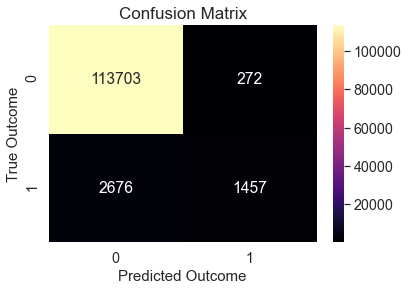

<Figure size 864x864 with 0 Axes>

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.84      0.35      0.50      4133

    accuracy                           0.98    118108
   macro avg       0.91      0.68      0.74    118108
weighted avg       0.97      0.98      0.97    118108



In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = clf.predict(X_test_te)

# get the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

matrix_df = pd.DataFrame(confusion_matrix)

# set axis to add title and axis labels later
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(12,12))

plot = sns.heatmap(matrix_df, annot=True, fmt='g', ax=ax, cmap = "magma")

#axis labels and title
ax.set_title('Confusion Matrix', fontsize = 17)
ax.set_xlabel('Predicted Outcome', fontsize = 15)
ax.set_ylabel('True Outcome', fontsize = 15)

plt.show()

fig = plot.get_figure()

print(metrics.classification_report(y_test, y_pred))